In [49]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
import tensorflow as tf
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
import math
import mysql.connector

mydb = mysql.connector.connect(
    host = "localhost",
    user = "root",
    password = "",
    database ='etl'
)
 
# Creating an instance of 'cursor' class
# which is used to execute the 'SQL'
# statements in 'Python'
cursor = mydb.cursor()
 
# Show database tables
cursor.execute("SHOW TABLES")
 
for x in cursor:
  print(x)

def sql_upload(pd_dataframe):
    for index, row in pd_dataframe.iterrows():
        cursor.execute("INSERT INTO bitcoin (unix,date,symbol,open,high,low,close,Volume_BTC,Volume_USD) values(%s,%s,%s,%s,%s,%s,%s,%s,%s)",(row['unix'],row['date'],row['symbol'],row['open'],row['high'],row['low'],row['close'],row['Volume BTC'],row['Volume USD']))
        mydb.commit()
    print("Successfully uploaded to sql table")
    
    
#df = pd.read_csv('csv/BTC-Daily.csv')
#df

('bitcoin',)
('crypto',)


,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1646092800,2022-03-01 00:00:00,BTC/USD,43221.71,43626.49,43185.48,43185.48,4.900629e+01,2.116360e+06
1,1646006400,2022-02-28 00:00:00,BTC/USD,37717.10,44256.08,37468.99,43178.98,3.160618e+03,1.364723e+08
2,1645920000,2022-02-27 00:00:00,BTC/USD,39146.66,39886.92,37015.74,37712.68,1.701817e+03,6.418008e+07
3,1645833600,2022-02-26 00:00:00,BTC/USD,39242.64,40330.99,38600.00,39146.66,9.127241e+02,3.573010e+07
4,1645747200,2022-02-25 00:00:00,BTC/USD,38360.93,39727.97,38027.61,39231.64,2.202852e+03,8.642149e+07
...,...,...,...,...,...,...,...,...,...
2646,1417478400,2014-12-02 00:00:00,BTC/USD,378.39,382.86,375.23,379.25,2.593576e+06,6.832530e+03
2647,1417392000,2014-12-01 00:00:00,BTC/USD,376.40,382.31,373.03,378.39,2.520662e+06,6.660560e+03
2648,1417305600,2014-11-30 00:00:00,BTC/USD,376.57,381.99,373.32,373.34,1.145567e+06,3.046330e+03
2649,1417219200,2014-11-29 00:00:00,BTC/USD,376.42,386.60,372.25,376.72,2.746157e+06,7.245190e+03


In [50]:
#Uploading to SQL 
#sql_upload(df)

In [52]:
df = pd.read_sql("SELECT * FROM crypto", con=mydb)
df

,ID,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,5756,Dogecoin,DOGE,2013-12-16,0.001,0.000,0.000,0.000,0.000000e+00,1.509085e+06
1,5757,Dogecoin,DOGE,2013-12-17,0.000,0.000,0.000,0.000,0.000000e+00,2.169688e+06
2,5758,Dogecoin,DOGE,2013-12-18,0.000,0.000,0.000,0.000,0.000000e+00,3.188943e+06
3,5759,Dogecoin,DOGE,2013-12-19,0.002,0.000,0.000,0.001,0.000000e+00,1.115034e+07
4,5760,Dogecoin,DOGE,2013-12-20,0.001,0.001,0.001,0.001,0.000000e+00,7.284337e+06
...,...,...,...,...,...,...,...,...,...,...
40579,46335,USD Coin,USDC,2021-07-02,1.001,1.000,1.000,1.000,1.787896e+09,2.539775e+10
40580,46336,USD Coin,USDC,2021-07-03,1.001,1.000,1.000,1.000,1.491017e+09,2.550437e+10
40581,46337,USD Coin,USDC,2021-07-04,1.000,0.999,1.000,1.000,1.578667e+09,2.551172e+10
40582,46338,USD Coin,USDC,2021-07-05,1.001,0.999,1.000,1.001,1.887496e+09,2.554724e+10


# **Preprosessing**

In [53]:
#df = pd.read_csv('/kaggle/input/btcinusd/BTC-Daily.csv')
# Removing all unessesary columns ( See Research )
df = df = df.drop(["Volume", "ID","Marketcap", "Symbol","Name","Open"], axis=1)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')
df.index = df.pop("Date")
df

,High,Low,Close
Date,,,
2013-04-29,4.574,4.226,4.384
2013-04-29,147.488,134.000,144.540
2013-04-29,147.488,134.000,144.540
2013-04-29,4.574,4.226,4.384
2013-04-30,4.572,4.169,4.296
...,...,...,...
2021-07-06,1.001,1.000,1.000
2021-07-06,2346.295,2197.919,2324.679
2021-07-06,34.978,32.930,34.269


# **Standardization**

In [54]:
# Scaler for N-Dimensional Array
df_features = df.drop(['Close'],axis=1)
df_np = df_features.to_numpy()
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_np, (-1,1))
df_scaled[0]

array([7.05177531e-05, 6.79323321e-05])

In [55]:
# Scaler for 1D array
df_close = pd.DataFrame(df['Close'])
df_close_np = df_close.to_numpy()
to_inverse_scale = MinMaxScaler()
df_close_scale = to_inverse_scale.fit_transform(df_close_np)
df_close_scale

array([[6.90356106e-05],
       [2.27609652e-03],
       [2.27609652e-03],
       ...,
       [5.39639904e-04],
       [4.09426523e-06],
       [1.57471740e-05]])

# **Converting Data to 3 Dimensions **

In [56]:
x = [] # The features needed for prediction.
y = [] # The expected result.

for i in range(len(df_scaled)-6):
    x.append(df_scaled[i:i+6])

for i in range(len(df_close_scale)-1):
        y.append(df_close_scale[i][0])


# Converting to Numpy array for easier reading by the ML-Algorithm
X = np.array(x)
Y = np.array(y)




# **Splitting the Data (Train/Test)**

In [57]:
train_no = math.floor(len(X) * 0.7) # 70% for training, 30% For Testing
total_no = len(X) 
X_Train, Y_Train = X[:train_no][:train_no], Y[:train_no]
X_Test, Y_Test = X[train_no: total_no - 1], Y[train_no: total_no - 1]

In [58]:
print(X_Train.shape, Y_Train.shape)
print(X_Test.shape, Y_Test.shape)

(28404, 6, 2) (28404,)
(12173, 6, 2) (12173,)


In [59]:
X_Train, Y_Train = X[:train_no], Y[:train_no]
X_Test, Y_Test = X[train_no: total_no - 1], Y[train_no: total_no - 1]

# **Developing The Model**

In [60]:
model = Sequential()
# Three layers, Final Output is in an array of 10 predictions
model.add(LSTM(30, return_sequences=True, input_shape=(6,2)))
model.add(LSTM(25, return_sequences=True))
model.add(LSTM(20, return_sequences=False))
model.add(Dense(15))
model.add(Dense(10))
          

In [61]:
model.compile(optimizer='adam', loss='mean_squared_error') # Compling the Model

In [62]:
modeled = model.fit(X_Train, Y_Train, batch_size=1, epochs=10) # Training the model

Epoch 1/10
28404/28404 [==============================] - 193s 7ms/step - loss: 9.1759e-05
Epoch 2/10
28404/28404 [==============================] - 196s 7ms/step - loss: 2.2715e-05
Epoch 3/10
28404/28404 [==============================] - 199s 7ms/step - loss: 1.2437e-05
Epoch 4/10
28404/28404 [==============================] - 186s 7ms/step - loss: 9.0060e-06
Epoch 5/10
28404/28404 [==============================] - 187s 7ms/step - loss: 6.8507e-06
Epoch 6/10
28404/28404 [==============================] - 194s 7ms/step - loss: 5.4719e-06
Epoch 7/10
28404/28404 [==============================] - 195s 7ms/step - loss: 5.2610e-06
Epoch 8/10
28404/28404 [==============================] - 195s 7ms/step - loss: 4.6944e-06
Epoch 9/10
28404/28404 [==============================] - 195s 7ms/step - loss: 4.6078e-06
Epoch 10/10
28404/28404 [==============================] - 195s 7ms/step - loss: 4.1070e-06


# **Testing the Model**

In [63]:
predictions = model.predict(X_Test)
predictions = to_inverse_scale.inverse_transform(predictions) # Reverse the standardization.


381/381 [==============================] - 4s 4ms/step


In [64]:
# Putting the predictions in an array to convert into dataframe column later.
valid = []
for i in range(len(predictions)):
    valid.append(predictions[i][9]) # Using the final prediction in the array.
    

# **Validating the Results**

In [65]:
new_df = pd.DataFrame(df[train_no: total_no - 1])

new_df = new_df.drop(["High","Low"], axis=1)

new_df['Prediction'] = valid


new_df

,Close,Prediction
Date,,
2019-11-19,55.624,63.867901
2019-11-19,0.003,28.584137
2019-11-19,1.010,47.313763
2019-11-19,8206.146,7699.603516
2019-11-19,0.043,17.781458
...,...,...
2021-07-06,0.260,-31.636822
2021-07-06,138.986,-89.564957
2021-07-06,0.234,773.820374


<AxesSubplot:xlabel='Date'>

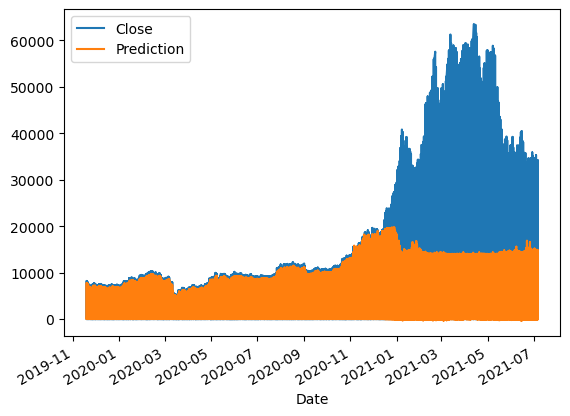

In [66]:
new_df.plot()

In [67]:
new_df.corr() # Accuracy around 99.5%

,Close,Prediction
Close,1.00000,0.84975
Prediction,0.84975,1.00000


In [68]:
test = X_Test[787:]

tests = model.predict(test)
tests =to_inverse_scale.inverse_transform(tests)
t = []
for i in range(len(tests)):
    t.append(tests[i][9])

t

356/356 [==============================] - 1s 4ms/step


[33.46597,
 29.624094,
 40.644417,
 6659.561,
 46.76776,
 47.028934,
 6618.237,
 90.4554,
 31.79485,
 26.187222,
 25.742472,
 25.977148,
 25.747204,
 26.245892,
 26.900713,
 90.608696,
 44.775852,
 31.7182,
 25.718815,
 25.789785,
 25.782215,
 45.031345,
 44.770176,
 26.871378,
 91.731926,
 18.683258,
 33.83975,
 34.69613,
 53.253532,
 6706.967,
 25.548487,
 26.269548,
 26.240213,
 26.999126,
 80.27726,
 33.785812,
 29.491615,
 41.6645,
 6667.4507,
 32.37113,
 45.47799,
 6852.236,
 6907.4907,
 25.833315,
 31.964231,
 25.673393,
 25.785055,
 25.777485,
 25.944975,
 45.301037,
 26.19763,
 26.115305,
 32.758156,
 93.48727,
 46.340992,
 93.58,
 27.492136,
 83.558945,
 33.983585,
 28.479101,
 52.72646,
 7008.955,
 46.973103,
 38.06487,
 108.71851,
 28.479101,
 46.901188,
 7009.149,
 26.273333,
 32.149704,
 25.762344,
 26.191954,
 25.534292,
 26.870432,
 19.39675,
 26.079346,
 103.74867,
 51.957134,
 7063.254,
 7128.3506,
 25.968632,
 26.1929,
 25.838047,
 26.452179,
 97.06986,
 46.569046,
 